In [2]:
import sys
import numpy as np
import pandas as pd
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pandas.tseries.offsets import DateOffset

%matplotlib inline
%precision 5
pd.set_option('precision', 2)
pd.set_option('max_rows', 20)
pd.set_option('max_columns', 10)

plt.rcParams["patch.force_edgecolor"] = True
sns.set(style="white",font_scale=1.4);

pd.options.mode.chained_assignment = None

# EDA 
__________________________________________

## Get Data

In [3]:

df = pd.read_csv('.\\assessment_new\\trainData.csv', parse_dates=['date'], 
                                                     index_col='date')
def describer(df):
    """Quick description of a DataFrame"""
    print('\nDataFrame Information: \n')
    print(df.info())
    print('\nThe beginning of the dataset is: \n\n', df.head())
    print('\nThe end of the dataset is: \n\n', df.tail())
    print('\nDescription of the demendent variable: \n')
    print(df.describe().transpose())
    print('\nThere are missing values in the data: ', df.isnull().values.any())

describer(df)


DataFrame Information: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36600 entries, 2011-01-01 to 2013-01-01
Data columns (total 3 columns):
code              36600 non-null int64
packages          36600 non-null float64
is_working_day    36600 non-null bool
dtypes: bool(1), float64(1), int64(1)
memory usage: 893.6 KB
None

The beginning of the dataset is: 

             code  packages  is_working_day
date                                      
2011-01-01     1     63.37           False
2011-01-01    10    125.97           False
2011-01-01    11    182.60           False
2011-01-01    12     36.37           False
2011-01-01    13     41.28           False

The end of the dataset is: 

             code  packages  is_working_day
date                                      
2013-01-01    50     46.70           False
2013-01-01     6    304.92           False
2013-01-01     7     33.96           False
2013-01-01     8     98.85           False
2013-01-01     9     99.95           F

## Preprocess

In [4]:

code_columns = list(map(str,np.sort(df.code.unique())))

ts = pd.DataFrame(index = df.index.unique(), 
                  columns=['Weekday', *code_columns] )

ts.index.names = ['Date']
for i in range(df.code.min(),df.code.max()+1):
    ts[str(i)] = df.loc[df['code']==i].packages

ts['Weekday'] = df.loc[df['code']==1]['is_working_day']

ts_tr = ts.loc['2011-01-01':'2012-06-30']
ts_te = ts.loc['2012-07-01':]
ts_tr.head()

,Weekday,1,2,3,4,...,46,47,48,49,50
Date,,,,,,,,,,,
2011-01-01,False,63.37,95.98,107.01,61.89,...,27.65,106.04,34.30,31.17,24.77
2011-01-02,False,48.69,115.94,137.77,46.88,...,32.05,139.38,34.54,24.69,24.07
2011-01-03,True,60.74,91.31,167.80,61.86,...,25.91,187.54,43.86,28.32,28.53
2011-01-04,True,87.34,87.56,148.82,84.45,...,30.10,109.01,33.31,40.14,23.31
2011-01-05,True,87.33,181.12,244.27,112.44,...,33.61,189.36,62.86,44.72,44.33


## Plot

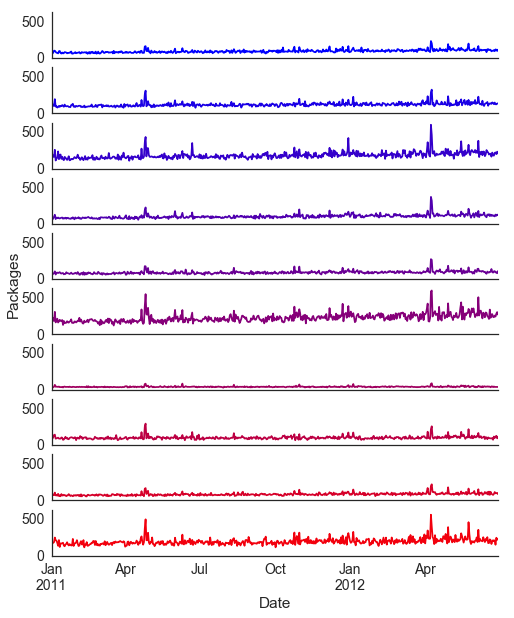

In [5]:
fig, axes = plt.subplots(nrows=10, ncols=1,figsize=(8,10), 
                                         sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', 
                                    left='off', right='off')
color=iter(plt.cm.brg(np.linspace(0,1,20)))
for p in range(1,11):
    ts_tr.iloc[:,p].plot(ax=axes[p-1], c=next(color))
    axes[p-1].spines['top'].set_visible(False)
    axes[p-1].spines["right"].set_visible(False)

plt.ylabel("Packages")
plt.show()


**Figure 1:**  Packages sent in each of the first 10 regions

We can make the following observations:
* Some time series seem to exibit a weak positive trend while ohers do not
* The series seem to be correlated with visible outliers around Easter and Christmas
* The series have different variability which seems to be correlated with the  
    mean number of packages sent (as one can expect)
* None of the time series seems to be lagging but this should be checked

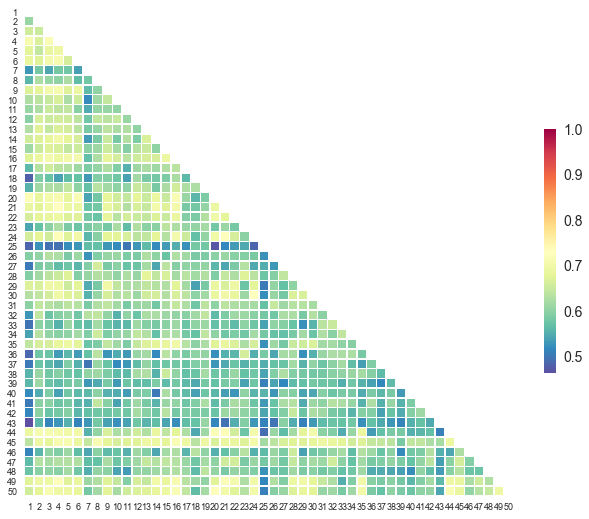

In [6]:

# Compute the correlation matrix
corr = ts_tr.iloc[:,1:51].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
h = sns.heatmap(corr, mask=mask, cmap="Spectral_r", 
            square=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5}, ax=ax);
h.set_xticklabels(h.get_xticklabels(), rotation = 0);
h.tick_params(axis='both', which='major', labelsize=9)

**Figure 2:** Cross-correlation between the 50 time series

We plan to treat each region seperately but we need to chech if any of the other  
regions can act as a predictor for the one we currently work with. We have to see  
if the time series of the region under consideration is correlated with the lagged  
series of any of the other 49

## Consider the First Region

In [7]:
cols= []
for i in range(1,101):
    c = 'Lag'+ str(i)
    cols.append(c)
    
lagged_corr= pd.DataFrame(index = ts_tr.columns[1:], 
                          columns = cols)

for j in range(1, lagged_corr.shape[0]+1):
    for i in range(1, lagged_corr.shape[1]+1):
        lagged_corr.iloc[j-1,i-1] = ts_tr.iloc[:,1:2] \
                                       .corrwith(ts_tr.iloc[:,j:j+1] \
                                                      .shift(i) \
                                                      .iloc[:,0])[0]


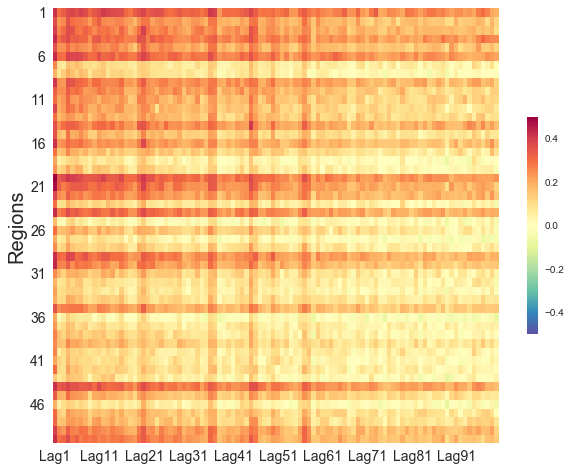

In [8]:
plt.figure(figsize=(10, 8))
sns.set(style="white",font_scale=1.0)
lagged_corr = lagged_corr[lagged_corr.columns].astype(float) 
h = sns.heatmap(lagged_corr, annot=False, 
                                cmap="Spectral_r", 
                                xticklabels = 10,
                                yticklabels = 5,
                                cbar_kws={"shrink": .5})
h.set_xticklabels(h.get_xticklabels(), rotation = 0);
h.set_yticklabels(h.get_yticklabels(), rotation = 0);
plt.ylabel("Regions", fontsize=20)
h.tick_params(axis='both', which='major', labelsize=14)

**Figure 3:**  Correlations between the time series for region 1 and  
               the lagged time series of the other regions at different lags

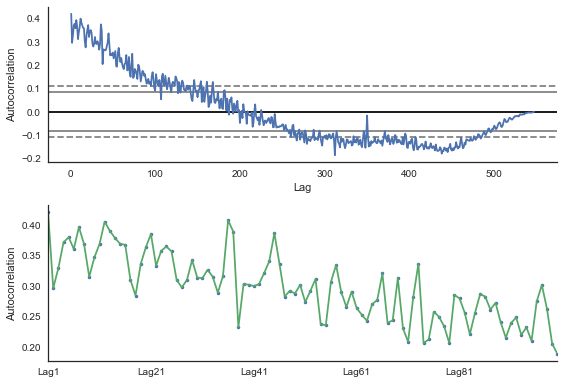

In [9]:
ts1 = ts_tr['1'].to_frame()

fig, axes = plt.subplots(nrows=2, ncols=1)

f1 = pd.plotting.autocorrelation_plot(ts1, ax=axes[0])
f1.grid(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

lagged_corr.iloc[0,:].plot(style=".", ax=axes[1]);
lagged_corr.iloc[0,:].plot( ax=axes[1])
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_ylabel("Autocorrelation")

plt.tight_layout()

**Figure 4:**  Autocorrelations for region 1. The second plot focuses on smaller lags.

Observations:
* persistent autocorrelation for the durration of a quater
* spike around 1 year

#### Original Time Series 

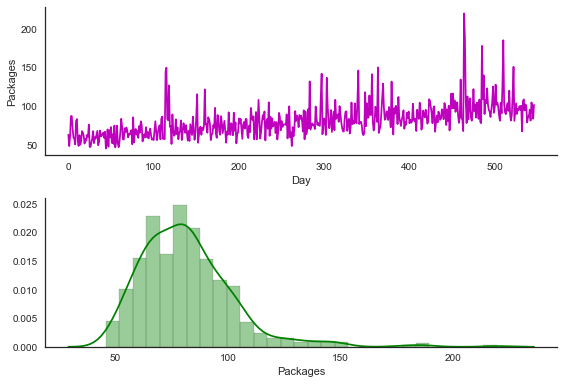

In [10]:

fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(ts1.values, c = 'm')
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].set_ylabel("Packages")
axes[0].set_xlabel("Day")


sns.distplot(ts1, ax=axes[1],color = 'g')
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_xlabel("Packages")

plt.tight_layout()

**Figure 5:**  Region 1 time series and distribution of the raw data

Some observations:

* The distribution is not Gaussian.
* The distribution has a long right tail, usually associated with exponential or polynomial behaviour. 
* We can consider log transformation

#### Log Time Series 

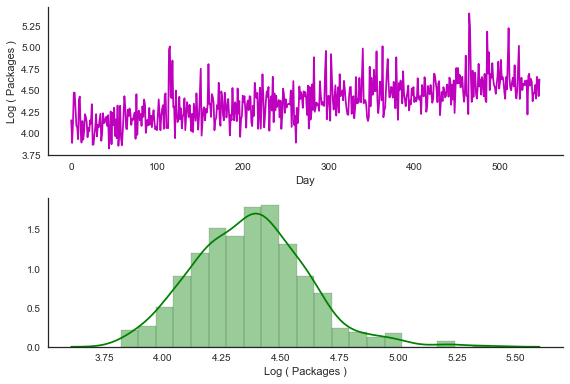

In [11]:
ts1['Log'] =  np.log(ts1) 

fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(ts1['Log'].values, c = 'm')
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].set_ylabel("Log ( Packages )")
axes[0].set_xlabel("Day")


sns.distplot(ts1['Log'], ax=axes[1],color = 'g')
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_xlabel("Log ( Packages )")

plt.tight_layout();

**Figure 6:**  Region 1 time series and distribution of the log transformed data

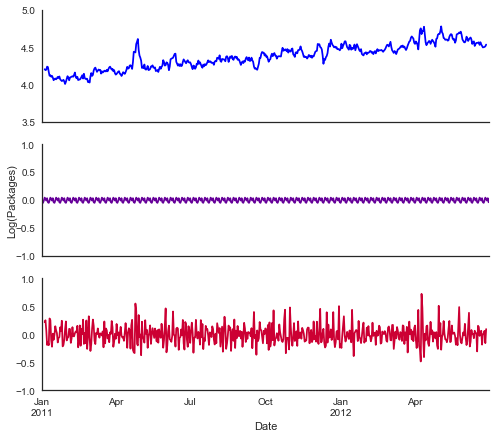

In [12]:
sd=sm.tsa.seasonal_decompose(ts1['Log'])

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,7), 
                                         sharex=True, sharey=False)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', 
                                    left='off', right='off')
color=iter(plt.cm.brg(np.linspace(0,1,6)))


sd.trend.plot(ax=axes[0], c=next(color))
axes[0].spines['top'].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].set_ylim(3.5, 5)

sd.seasonal.plot(ax=axes[1], c=next(color))
axes[1].spines['top'].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_ylim(-1, 1)

sd.resid.plot(ax=axes[2], c=next(color))
axes[2].spines['top'].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_ylim(-1, 1)

plt.ylabel("Log(Packages)")
plt.show()

**Figure 7:** Trend, seasonality and residuals for the log transformed data

In [13]:

dftest = adfuller(ts1['Log'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -1.56
p-value                          0.50
#Lags Used                      15.00
Number of Observations Used    531.00
Critical Value (1%)             -3.44
Critical Value (5%)             -2.87
Critical Value (10%)            -2.57
dtype: float64

Since the time series is not stationary we are going to apply first order differencing

#### $\Delta$Log Time Series  - Stationary

In [14]:
ts1['Log_diff'] = ts1['Log'].diff().dropna()



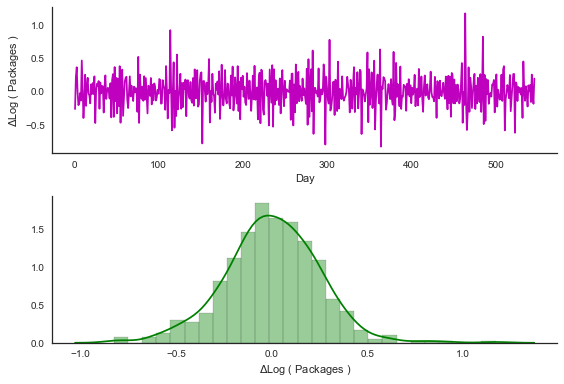

In [15]:

fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(ts1['Log_diff'].values, c = 'm')
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].set_ylabel(r'$\Delta$'"Log ( Packages )")
axes[0].set_xlabel("Day")


sns.distplot(ts1['Log_diff'].dropna(), ax=axes[1],color = 'g')
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_xlabel(r'$\Delta$'"Log ( Packages )")

plt.tight_layout();

**Figure 8:**  Region 1 time series and distribution of the first order difference for the log transformed data

In [16]:

dftest = adfuller(ts1['Log_diff'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.10e+01
p-value                        5.87e-20
#Lags Used                     1.40e+01
Number of Observations Used    5.31e+02
Critical Value (1%)           -3.44e+00
Critical Value (5%)           -2.87e+00
Critical Value (10%)          -2.57e+00
dtype: float64

The series is **stationary** after the last transformation and we can procede to an ARIMA model.

## ARIMA Model 

Grid Search for the parameters of a non-seasonal ARIMA model

In [17]:

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
warnings.filterwarnings("ignore")
for param in pdq:
    try:
        mod = ARIMA(ts1['Log_diff'].dropna(), order=param)

        results = mod.fit(trend='nc', disp=0)

        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 1) - AIC:-294.2844675848314
ARIMA(0, 0, 2) - AIC:-293.6523769309531
ARIMA(0, 1, 1) - AIC:37.17571862915224
ARIMA(0, 2, 1) - AIC:605.3061459740014
ARIMA(1, 0, 0) - AIC:-76.15524162474753
ARIMA(1, 0, 1) - AIC:-293.3485591843669
ARIMA(1, 0, 2) - AIC:-293.6993386822596
ARIMA(1, 0, 3) - AIC:-297.6827527922262
ARIMA(1, 1, 0) - AIC:346.0146528355526
ARIMA(1, 2, 0) - AIC:849.3403254095848
ARIMA(2, 0, 0) - AIC:-142.78719967574784
ARIMA(2, 0, 1) - AIC:-298.29694489720964
ARIMA(2, 0, 2) - AIC:-298.12511243153403
ARIMA(2, 0, 3) - AIC:-296.27385767735245
ARIMA(2, 1, 0) - AIC:208.64691893689974
ARIMA(2, 2, 0) - AIC:638.8449424800771
ARIMA(3, 0, 0) - AIC:-188.23447653742824
ARIMA(3, 0, 1) - AIC:-298.1133517899525
ARIMA(3, 0, 2) - AIC:-296.2471042171928
ARIMA(3, 1, 0) - AIC:114.42760202693307
ARIMA(3, 2, 0) - AIC:499.49890909804094


We pick  (2,0,1) set of hyperparameters

In [18]:

model = SARIMAX(ts1['Log_diff'].to_frame(), order=(2,0,1) )
results = model.fit(trend='nc', disp=0)
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0403      0.034      1.194      0.232      -0.026       0.106
ar.L2         -0.1175      0.045     -2.596      0.009      -0.206      -0.029
ma.L1         -0.9392      0.017    -56.700      0.000      -0.972      -0.907
sigma2         0.0333      0.002     22.154      0.000       0.030       0.036


Our primary concern is to ensure that the residuals of our model are uncorrelated and  
normally distributed with zero-mean. This seems to be the case.

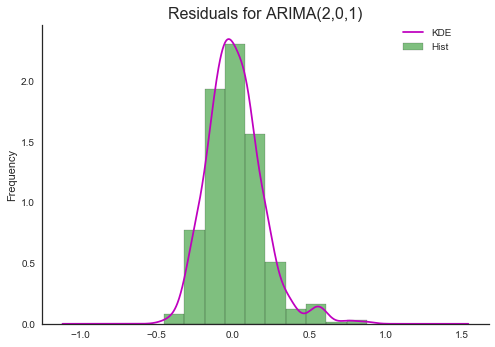

In [19]:

results.resid.plot(kind='kde', c='m', label="KDE")
results.resid.plot(kind='hist', normed=True, color='g',alpha=0.5,label="Hist");
plt.legend(bbox_to_anchor=(0.80, 1), loc=2, borderaxespad=0.)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Residuals for ARIMA(2,0,1)', fontsize=16)
plt.show()



Unfortunately the ARIMA model is not suitable for making the prediction for 2013  
but was nontheless informative about the nature of our data 

  
  
  
  
  


 

# Model
__________________________________________

In [20]:

df = pd.read_csv('.\\assessment_new\\trainData.csv', parse_dates=['date'], 
                                                     index_col='date')
hd = pd.read_csv('.\\assessment_new\\holidays.csv', parse_dates=['date'], 
                                                     index_col='date')

In [21]:

data = pd.get_dummies(df.code.astype('str'), prefix='c')
data['day_of_week'] = data.index.dayofweek
data['day_of_week'] = data['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 
                                               2: 'Wednesday', 3: 'Thursday', 
                                               4: 'Friday', 5: 'Saturday', 
                                               6: 'Sunday'})
data = pd.concat([data, 
                  pd.get_dummies(data['day_of_week'].astype('str'))], 
                 axis=1)
data.drop('day_of_week',axis=1,inplace=True)

In [22]:
data['month'] = data.index.month
data = pd.concat([data, 
                  pd.get_dummies(data['month'].astype('str'), prefix='m')], 
                 axis=1)
data.drop('month',axis=1,inplace=True)

data['event']= hd
data = pd.concat([data, 
                  pd.get_dummies(data.event.astype('str'))], 
                 axis=1)
data.drop('event',axis=1,inplace=True)


In [23]:
for i,date in enumerate(data.index.unique()[::-1]):

    if data.loc[date,'nan'][0] != 0 and i>0:
        data.loc[date,'nan'] = data.loc[date,'nan']  \
                            + data.loc[data.index.unique()[::-1][i-1],'nan'][0]

data.rename(columns={'nan': 'days_until_holiday'}, inplace=True)

In [24]:
data['working_day'] = df.is_working_day.astype(int)
data['day_count'] = np.nan
for i, date in enumerate(data.index):
    if i%50==0:
        data.loc[date,'day_count'] = (i/50)
data = pd.concat([data,df.packages.to_frame()],axis=1)



In [25]:

train_ends = '2012-06-30'
test_starts = '2012-07-1'

X_tr = data.loc[:train_ends,:]
X_te = data.loc[test_starts:,:]

Y_tr = X_tr.loc[:train_ends,'packages']
Y_te = X_te.loc[test_starts:,'packages']

X_tr.columns.values


array(['c_1', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16',
       'c_17', 'c_18', 'c_19', 'c_2', 'c_20', 'c_21', 'c_22', 'c_23',
       'c_24', 'c_25', 'c_26', 'c_27', 'c_28', 'c_29', 'c_3', 'c_30',
       'c_31', 'c_32', 'c_33', 'c_34', 'c_35', 'c_36', 'c_37', 'c_38',
       'c_39', 'c_4', 'c_40', 'c_41', 'c_42', 'c_43', 'c_44', 'c_45',
       'c_46', 'c_47', 'c_48', 'c_49', 'c_5', 'c_50', 'c_6', 'c_7', 'c_8',
       'c_9', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'm_1', 'm_10', 'm_11', 'm_12', 'm_2', 'm_3',
       'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', "All Saints' Day",
       'Ascension Day', 'Assumption Day', 'Christmas Day',
       'Corpus Christi', 'Easter', 'Epiphany', 'Immaculate Conception',
       'Labor Day', 'National Day', "New Year's Day", "St. Stephen's Day",
       'Whit Monday', 'days_until_holiday', 'working_day', 'day_count',
       'packages'], dtype=object)

## Detrend by Region

In [26]:

data ['trend']=np.nan
for i in range(1,51):
    lr = LinearRegression()
    days_tr  = X_tr[X_tr['c_'+str(i)]==1]['day_count']
    days_te  = X_te[X_te['c_'+str(i)]==1]['day_count']
    packs = X_tr[X_tr['c_'+str(i)]==1]['packages']
    
    days_tr_no_outliers = days_tr.drop(days_tr.nlargest(20).index)
    packs.drop(days_tr.nlargest(20).index, inplace=True)
    
    #fitted only on test data!
    lr.fit(days_tr_no_outliers.values.reshape(-1, 1), 
           packs.values.reshape(-1, 1))

    X_tr.loc[X_tr['c_'+str(i)]==1, 'trend'] = lr.intercept_[0] +  \
                                                lr.coef_[0][0]*days_tr
    X_te.loc[X_te['c_'+str(i)]==1, 'trend'] = lr.intercept_[0] + \
                                                lr.coef_[0][0]*days_te


In [27]:

Y_tr = Y_tr -  X_tr.trend
trend = X_te.trend

X_tr.drop('packages',1, inplace=True)
X_te.drop('packages',1, inplace=True)
X_tr.drop('trend',1, inplace=True)
X_te.drop('trend',1, inplace=True)


## Random Forest Regression

In [28]:

def pred_ints(model, X, percentile=95):
    """Confidence intervals using quantile regression forest"""
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.iloc[x:x+1,:]).mean())
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up


In [29]:


regr = RandomForestRegressor(n_estimators=1000, criterion='mse', n_jobs=2,
                                min_samples_split = 2,
                                min_samples_leaf=1,
                                random_state=123)


In [30]:
regr.fit(X_tr, Y_tr)
Y_hat = regr.predict(X_te) + trend

err_down, err_up = pred_ints(regr, X_te, percentile=95)
err_down = Y_hat - (pd.Series(err_down, index=Y_te.index)+ trend) 
err_up =  (pd.Series(err_up, index=Y_te.index)+ trend)  - Y_hat 


## Result

In [31]:
sum(abs(Y_hat-Y_te))/max(sum(abs(Y_te)),1)

0.13145

Choose region_code between 1 and 50 and see the performance  
of our model in the corresponding region

In [37]:
region_code =15

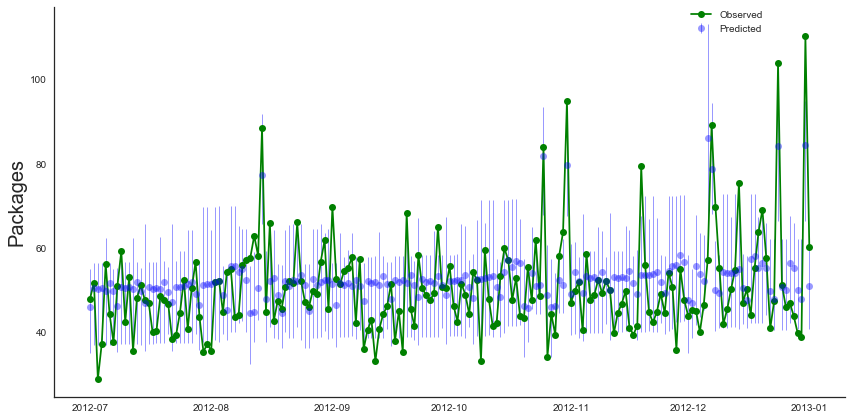

In [38]:
plt.figure(figsize=(12, 6))
plt.errorbar(X_te.loc[X_te['c_'+str(region_code)]==1, 'day_count'].index, 
             Y_hat.loc[X_te['c_'+str(region_code)]==1].values, 
             yerr=[err_down.loc[X_te['c_'+str(region_code)]==1].values, 
                   err_up.loc[X_te['c_'+str(region_code)]==1].values], 
             capsize=5, fmt='o',c='b', alpha = 0.4,elinewidth=1,  
             ecolor='b',ls = 'none', label='Predicted')

plt.plot(X_te.loc[X_te['c_'+str(region_code)]==1, 'day_count'].index, 
             Y_te.loc[X_te['c_'+str(region_code)]==1].values , 
             marker='o', c='g', label='Observed')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylabel("Packages", fontsize=20)
plt.legend(bbox_to_anchor=(0.80, 1), loc=2, borderaxespad=0.)
plt.tight_layout();


**Figure 10:** Model evaluation for the chosen region